# Proyecto 1. Entrega 2.
# Algoritmos de Aprendizaje no Supervisado

In [29]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

## 1. Clustering

### 1.1. Preprocesamiento del dataset

In [30]:
# Cargar el dataset
try:
    df = pd.read_csv('movies.csv', encoding='utf-8')
except UnicodeDecodeError:
    try:
        df = pd.read_csv('movies.csv', encoding='latin-1')  
    except UnicodeDecodeError:
        df = pd.read_csv('movies.csv', encoding='utf-8', errors='replace')

# Eliminar columnas irrelevantes
drop_columns = ['id', 'originalTitle', 'title', 'homePage', 'actorsCharacter', 'video']
df = df.drop(columns=drop_columns)

# Codificación one-hot para variables categóricas
categorical_cols = ['originalLanguage', 'productionCompanyCountry']
df = pd.get_dummies(df, columns=categorical_cols)

# Normalización de variables numéricas
scaler = StandardScaler()
numerical_cols = ['popularity', 'budget', 'revenue', 'runtime', 'voteCount', 'voteAvg', 'actorsPopularity', 'actorsAmount', 'castWomenAmount', 'castMenAmount', 'genresAmount', 'productionCoAmount', 'productionCountriesAmount']
# Convertir a números y manejar errores
for col in numerical_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Llenar NaN con la mediana
df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].median())

# Normalización
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])


### 1.2. Análisis de tendencia al agrupamiento

In [31]:
def hopkins_statistic(X, sample_size=50):
    n, d = X.shape
    sample_indices = np.random.choice(n, sample_size, replace=False)
    random_points = np.random.uniform(np.min(X, axis=0), np.max(X, axis=0), (sample_size, d))
    
    nbrs = NearestNeighbors(n_neighbors=1).fit(X)
    distances_real, _ = nbrs.kneighbors(X[sample_indices], n_neighbors=1)
    distances_random, _ = nbrs.kneighbors(random_points, n_neighbors=1)
    
    H = np.sum(distances_random) / (np.sum(distances_real) + np.sum(distances_random))
    return H

H_stat = hopkins_statistic(df[numerical_cols].values)
print(f'Estadístico de Hopkins: {H_stat}')

Estadístico de Hopkins: 1.0


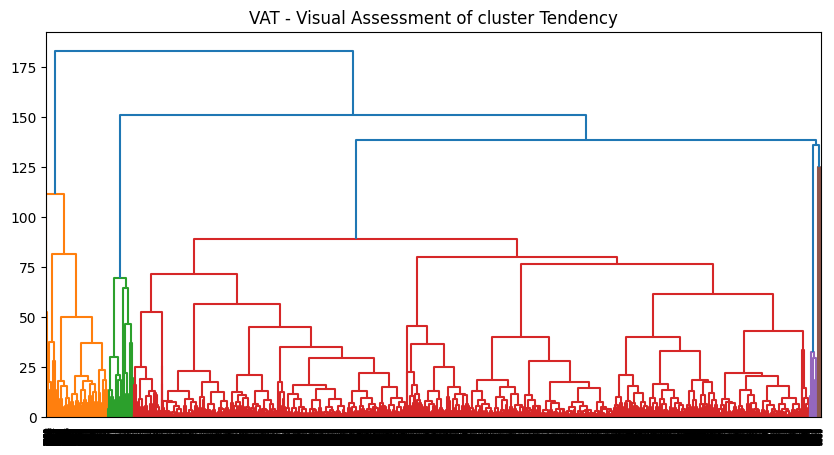

In [32]:
# VAT (Visual Assessment of cluster Tendency)
Z = linkage(df[numerical_cols], method='ward')
plt.figure(figsize=(10, 5))
dendrogram(Z)
plt.title('VAT - Visual Assessment of cluster Tendency')
plt.show()

### 1.3. Determinación del número óptimo de clústeres

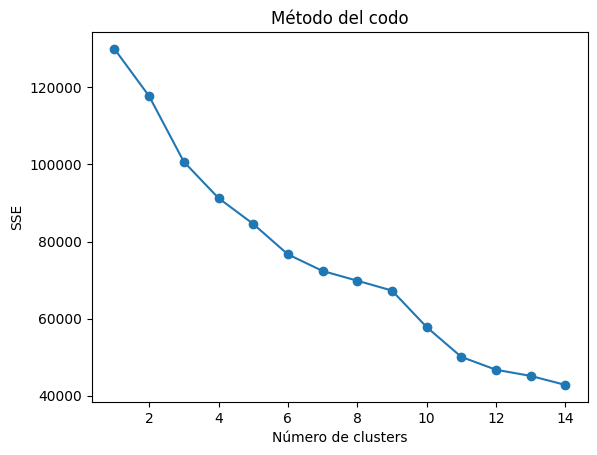

In [33]:
sse = []
k_values = range(1, 15)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42).fit(df[numerical_cols])
    sse.append(kmeans.inertia_)

plt.plot(k_values, sse, marker='o')
plt.xlabel('Número de clusters')
plt.ylabel('SSE')
plt.title('Método del codo')
plt.show()